In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


In [115]:
win_counts = np.array([
    [0.0, 14.0, 29.5, 20.5, 3.5, 5.5],
    [754.0, 0.0, 94.5, 205.5, 115.5, 91.0],
    [738.5, 673.5, 0.0, 222.5, 199.0, 303.5],
    [747.5, 562.5, 545.5, 0.0, 396.5, 247.5],
    [764.5, 652.5, 569.0, 371.5, 0.0, 250.0],
    [762.5, 677.0, 464.5, 520.5, 518.0, 0.0]
])


path = "/Users/kartikpingle/Desktop/gorilla_ablation"

# this folder contains 4 folders: 0, 1, 2, 3
# 0 contains folders from 0 to 95
# 1 contains folders from 96 to 191
# 2 contains folders from 192 to 287
# 3 contains folders from 288 to 383
# all innermost folders have logs.txt files

for i in range(4):
    for j in range(96):
        with open(f"{path}/{i}/{i * 96 + j}/log.txt", "r") as f:
            with open("ALL_LOGS.txt", "a") as f2:
                f2.write(f.read())



In [2]:
def parse_game_log(file_path):
    game_logs = []
    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove any leading/trailing whitespace
            parts = line.split()  # Split the line into parts
            
            if len(parts) == 3:  # Ensure the line is correctly formatted
                player_i = int(parts[0])  # First part: index of player i
                player_j = int(parts[1])  # Second part: index of player j
                result = int(parts[2])  # Third part: game result (-1, 0, 1)

                # Create a dictionary for this game log
                game_log = {
                    'player_i': player_i,
                    'player_j': player_j,
                    'result': result
                }

                # Append the dictionary to the list
                game_logs.append(game_log)

    return game_logs


In [3]:
def update_elo(ratings, player_i, player_j, result, k=32):
    # Calculate expected scores
    E_i = 1 / (1 + 10 ** ((ratings[player_j] - ratings[player_i]) / 400))
    E_j = 1 / (1 + 10 ** ((ratings[player_i] - ratings[player_j]) / 400))

   
    if result == 0:  # Player i wins
        S_i, S_j = 1, 0
    elif result == 1:  
        S_i, S_j = 0, 1
    else:  # Draw
        S_i, S_j = 0.5, 0.5

    # Update ratings
    ratings[player_i] += k * (S_i - E_i)
    ratings[player_j] += k * (S_j - E_j)

In [4]:
def compute_elo_from_logs(game_logs):

    # Initialize ratings (assuming no player indices beyond what's seen in the logs)
    ratings = {}
    for log in game_logs:
        ratings[log['player_i']] = 1500
        ratings[log['player_j']] = 1500
    np.random.seed(101)
    np.random.shuffle(game_logs)

    # Process each game
    for log in game_logs:
        update_elo(ratings, log['player_i'], log['player_j'], log['result'])

    return ratings


In [5]:
logs_file_oath = "ALL_LOGS.txt"

game_logs = parse_game_log(logs_file_oath)

elos = compute_elo_from_logs(game_logs)

# for elo in elos:
#     print(f"Bot {elo} has an ELO: {elos[elo]}")

idx_to_name = {
    "0": "random",
    "1": "none_1_itrs",
    "2": "none_2_itrs",
    "3": "none_3_itrs",
    "4": "none_4_itrs",
    "5": "none_5_itrs",
    "6": "linear_1_itrs",
    "7": "linear_2_itrs",
    "8": "linear_3_itrs",
    "9": "linear_4_itrs",
    "10": "linear_5_itrs",
    "11": "pq_1_itrs",
    "12": "pq_2_itrs",
    "13": "pq_3_itrs",
    "14": "pq_4_itrs",
    "15": "pq_5_itrs",
    "16": "reset_1_itrs",
    "17": "reset_2_itrs",
    "18": "reset_3_itrs",
    "19": "reset_4_itrs",
    "20": "reset_5_itrs",
    "21": "sym_1_itrs",
    "22": "sym_2_itrs",
    "23": "sym_3_itrs",
    "24": "sym_4_itrs",
    "25": "sym_5_itrs",
    "26": "flamingo_1_itrs",
    "27": "flamingo_2_itrs",
    "28": "flamingo_3_itrs",
    "29": "flamingo_4_itrs",
    "30": "flamingo_5_itrs"
}


final_elos = {}

for key in elos:
    final_elos[idx_to_name[str(key)]] = elos[key]
with open('elos_1.pkl', 'wb') as f:
    pickle.dump(final_elos, f)



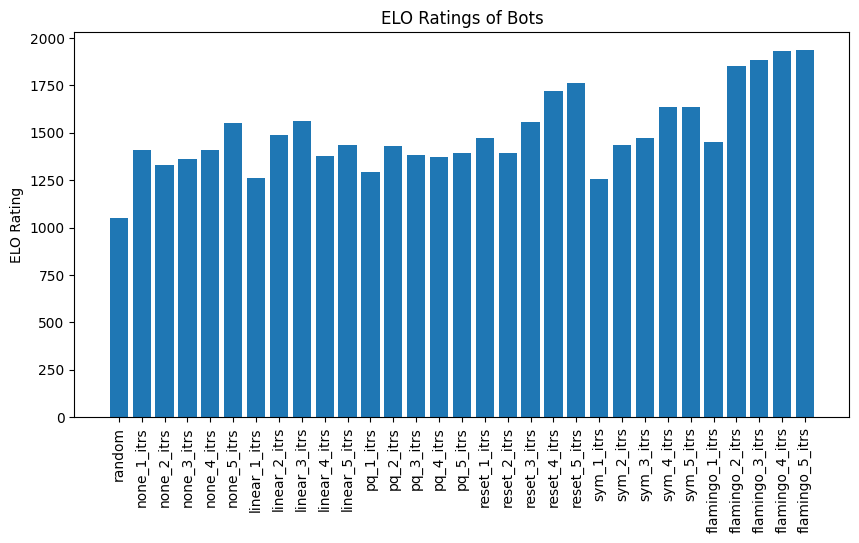

In [8]:
# plot the final elos in a line graph where the x-axis is the number of iterations and the y-axis is the elo rating
plt.figure(figsize=(10, 5))
plt.plot()